# Combined Mitigation

In [1]:
from my_rem import *
from my_ddd import *
from my_lib import *

from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, phase_damping_error, phase_amplitude_damping_error

In [2]:
# Error Parameters
p_readout_flip = 0.00
p_circuit_depolarizing = 0.1
gamma_dephasing = 0.1
gamma_amplitude_damping = 0.1
thermal_population = 0.1

# Possible Errors 
error_meas = pauli_error([('X', p_readout_flip), ('I', 1 - p_readout_flip)])
error_depolarizing_1q = depolarizing_error(p_circuit_depolarizing, 1)
error_depolarizing_2q = depolarizing_error(p_circuit_depolarizing, 2)
error_dephasing_1q = phase_damping_error(gamma_dephasing)
error_phase_amplitude_damping = phase_amplitude_damping_error(gamma_dephasing, gamma_amplitude_damping, thermal_population)

# Example Usage

In [3]:
num_qubits = 2  # Number of qubits in the circuit

# Initialize a random circuit
num_operations = 5  # Number of initial random operations
idle_depth = 20  # Number of idle operations to add
circuit = create_random_circuit_with_idle_windows(num_qubits, num_operations, idle_depth)

#create the mitigator, that will be applied a posteriori
mitigator_shots = 1000
readout_noise = get_readout_noise(error_meas)
mitigator_instance = generate_mitigator(num_qubits, mitigator_shots, readout_noise, False)

In [9]:
# Define other parameters
reps = 100000
noise = get_combined_noise(error_meas, error_phase_amplitude_damping)
ddd_flag = True
shots = 10000
ddd_sequence = ddd.rules.xx  # Use appropriate DDD sequence from mitiq

# Apply DDD (if required) and run the circuit
counts = apply_ddd_and_run(
    circuit,
    noise=noise,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=False
)

print(counts)

# Apply the mitigator (if required) to the results
probabilities = apply_mitigator(
    counts,
    n_qubits=num_qubits,
    reps=reps,
    mitigator_instance=mitigator_instance,
    output=False
)

print(probabilities)

{'11': 14129, '01': 8265, '10': 68706, '00': 8900}
{'00': 0.089, '01': 0.08265, '10': 0.68706, '11': 0.14129}


# Statistics from a large sample of runs

In [10]:
# Assuming you have already defined the circuit, noise model, and other necessary parameters
result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd = run_cases(circuit, noise=noise, reps=1000, n_qubits=2, ddd_rule=ddd.rules.xyxy)
results_list = [result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd]
print(results_list)

Running with no noise, no mitigation ... 

Final Probabilities={'00': 0.0, '01': 0.0, '10': 1.0, '11': 0.0}

 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False ... 

Running with noise, mitigation False, DDD True ... 

Running with noise, mitigation True, DDD True ... 

[{'00': 0.0, '01': 0.0, '10': 1.0, '11': 0.0}, {'00': 0.007, '01': 0.076, '10': 0.829, '11': 0.088}, {'00': 0.011, '01': 0.08, '10': 0.818, '11': 0.091}, {'00': 0.156, '01': 0.112, '10': 0.564, '11': 0.168}, {'00': 0.127, '01': 0.093, '10': 0.606, '11': 0.174}]


Text(0, 0.5, 'Probabilities')

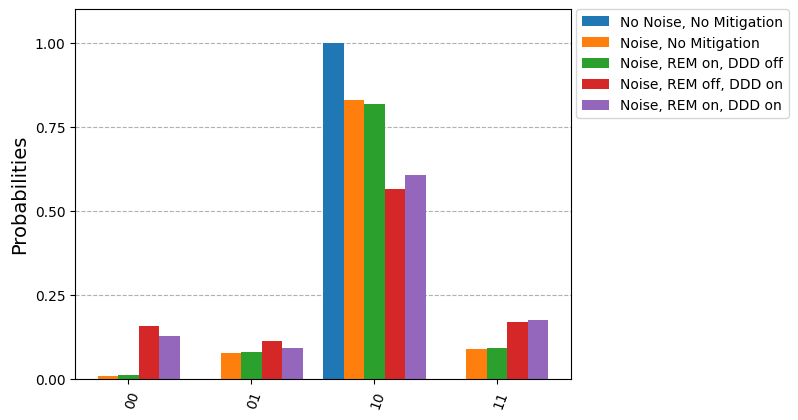

In [11]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


labels = [
    'No Noise, No Mitigation', 'Noise, No Mitigation',
    'Noise, REM on, DDD off', 'Noise, REM off, DDD on', 'Noise, REM on, DDD on'
]


# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Now, use the ax parameter to specify where to plot the histogram
plot_histogram(results_list, legend=labels, bar_labels=False, ax=ax)
ax.set_ylabel('Probabilities')

# Study the Performance based on distance

In [7]:
n = 10  # Number of repetitions (number of random circuits)
num_qubits = 2  # Number of qubits in the circuit
num_operations = 5  # Number of initial random operations
idle_depth = 20  # Number of idle operations to add
noise = noise  # Define your noise model here
reps = 1000
shots = 10000
ddd_rule = ddd.rules.xyxy  # Define your DDD rule here

# Run experiment
avg_distances = run_experiment(n, num_qubits, num_operations, idle_depth, noise, reps, shots, ddd_rule)

Running experiment 0... 

Running with no noise, no mitigation ... 

Final Probabilities={'00': 1.0, '01': 0.0, '10': 0.0, '11': 0.0}

 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False ... 

Running with noise, mitigation False, DDD True ... 

Running with noise, mitigation True, DDD True ... 

Running experiment 1... 

Running with no noise, no mitigation ... 

Final Probabilities={'00': 0.0, '01': 0.491, '10': 0.0, '11': 0.509}

 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False ... 

Running with noise, mitigation False, DDD True ... 

Running with noise, mitigation True, DDD True ... 

Running experiment 2... 

Running with no noise, no mitigation ... 

Final Probabilities={'00': 0.235, '01': 0.232, '10': 0.251, '11': 0.282}

 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False ... 

Running with noise, mitigation False, DDD True ... 

Running with noise, mitigation T

In [8]:
# Print average distances
print("Average distance to result_noise_no_mit from ideal :", avg_distances[0])
print("Average distance to result_noise_rem_no_ddd from ideal :", avg_distances[1])
print("Average distance to result_noise_no_rem_ddd from ideal :", avg_distances[2])
print("Average distance to result_noise_rem_ddd from ideal :", avg_distances[3])

Average distance to result_noise_no_mit from ideal : 0.145345391223404
Average distance to result_noise_rem_no_ddd from ideal : 0.141546922014928
Average distance to result_noise_no_rem_ddd from ideal : 0.320464205475759
Average distance to result_noise_rem_ddd from ideal : 0.31582485313232916


DDD is making the results worse!!!!!